In [221]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from tqdm import tqdm 

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint


from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers,initializers
from tensorflow.keras.initializers import HeUniform,GlorotUniform

In [179]:
import logging
logging.getLogger('lightgbm').setLevel(logging.ERROR)
warnings.filterwarnings(action = 'ignore')
plt.style.use('ggplot')

In [54]:
df = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/train.csv').drop('id',axis = 1)
test = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/test.csv').drop('id',axis = 1)
sub = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/sample_submission.csv')

In [55]:
def scaler(col):
    
    min_ = np.min(col)
    max_ = np.max(col)
    
    return (col - min_) / (max_ - min_)

In [56]:
cols = df.columns[:-1]

for col in cols:
    df[col] = scaler(df[col])
    
for col in cols:
    test[col] = scaler(test[col])

In [57]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state = 42,
                                                    test_size = 0.1)

In [121]:
def grid_search(models,param_grid, cv = 5):
    
    global x_train,y_train,x_test,y_test
    
    result_model = {}
    params = {}
    predicted = {}
    scoring = {}
    
    for name,model in tqdm(models.items()):
        
        params = param_grid[name]
        
        grid_model = GridSearchCV(estimator = model, param_grid = params, cv = cv, 
                        scoring = 'neg_mean_absolute_error', verbose = 1)
        
        grid_model.fit(x_train,y_train)
        best_model = grid_model.best_estimator_

        result_model[name] = best_model
        params[name] = best_model.get_params()
        scoring[name] = grid_model.best_score_
        predicted[name] = grid_model.best_estimator_.predict(x_test)
        
        
    return result_model,params,predicted,scoring 

In [123]:
models = {'RandomForestRegressor':RandomForestRegressor(),
            'XGBoostRegressor': XGBRegressor(),
            'LGBMRegressor': LGBMRegressor(silent = True, verbosity = 0),
            'CatBoostRegressor':CatBoostRegressor(silent = True)}

params = {}

params['RandomForestRegressor'] ={
    'n_estimators': [100,300,500],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

params['XGBoostRegressor'] =  {
    'n_estimators': [100,300,500],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

params['LGBMRegressor'] = {
    'n_estimators': [100,300,500],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

params['CatBoostRegressor'] = {
    'iterations': [50, 100],
    'depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'bagging_temperature': [0.8, 1.0],
    'random_strength': [0.1, 0.5]
}


In [124]:
results = grid_search(models,params)

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


 25%|██▌       | 1/4 [07:53<23:40, 473.39s/it]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


 50%|█████     | 2/4 [13:15<12:48, 384.40s/it]

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

 75%|███████▌  | 3/4 [15:32<04:31, 271.65s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


100%|██████████| 4/4 [17:31<00:00, 262.96s/it]


Text(0.5, 0.98, 'Residual Plot')

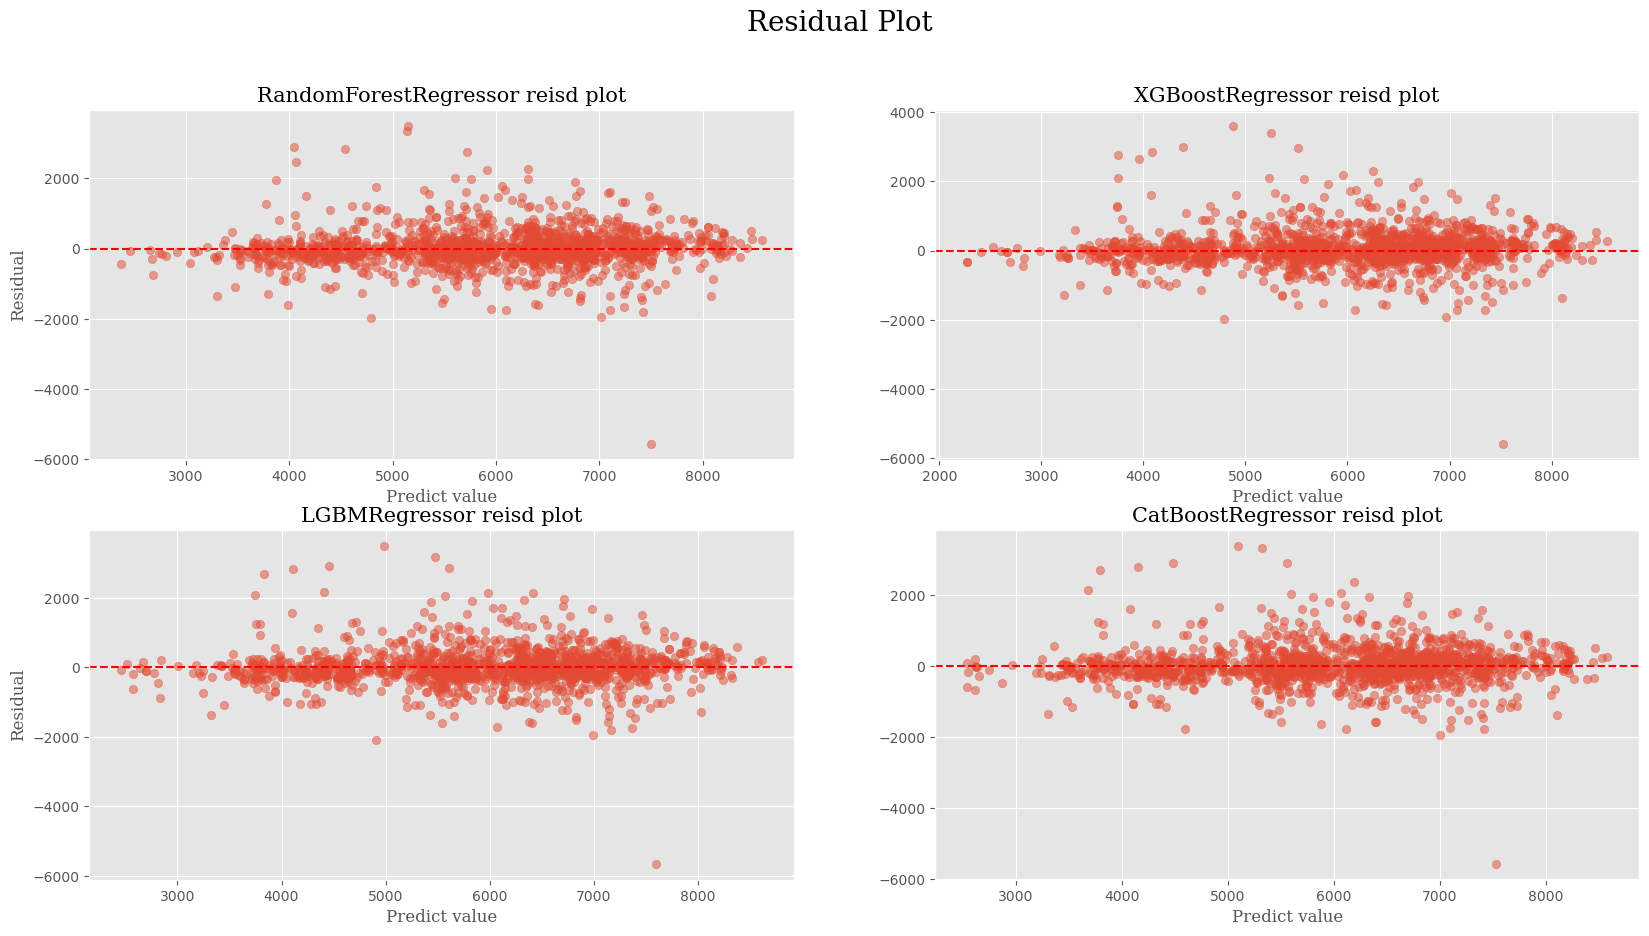

In [193]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = (20,10))
ax = ax.flatten()

for i,(name,pred) in enumerate(results[2].items()):
    
    ax[i].scatter(pred,y_test - pred, alpha = 0.5)
    ax[i].axhline(0, c = 'r', ls = '--')
    ax[i].set_title(f'{name} reisd plot', fontsize = 15 ,fontfamily = 'serif')
    ax[i].set_xlabel('Predict value', fontfamily = 'serif')
    if i % 2 == 0:
        ax[i].set_ylabel('Residual', fontfamily  ='serif')
    
fig.suptitle('Residual Plot', fontfamily = 'serif', fontsize = 20)

In [204]:
total_weight = sum([np.abs(w) for w in results[3].values()])

weights = {}

for name,score in results[3].items():
    
    weights[name] = np.abs(score) / total_weight
    
weights

{'RandomForestRegressor': 0.2525955622233132,
 'XGBoostRegressor': 0.2483832877272491,
 'LGBMRegressor': 0.24921312312360147,
 'CatBoostRegressor': 0.24980802692583617}

In [208]:
zeros = np.zeros(shape = len(y_test))


for name,pred in results[2].items():
    
    zeros += pred * weights[name]

In [216]:
mean_absolute_error(y_test,zeros) # 가중치를 이용한 앙상블 모델 

343.1524646960727

In [219]:
for name,pred in results[2].items():
    
    print('**'*20)
    print(name)
    print(mean_absolute_error(y_test,pred))

****************************************
RandomForestRegressor
347.18378452640457
****************************************
XGBoostRegressor
345.0898796942957
****************************************
LGBMRegressor
344.29449959554506
****************************************
CatBoostRegressor
347.0402133464926


In [283]:
def create_model(SHAPE,FIRST_NODE,L2,LAYERS,DROPOUT_RATE,HIDDEN_NODE):
    
    input_ = tf.keras.Input(SHAPE)
    
    x = tf.keras.layers.BatchNormalization()(input_)
    x = tf.keras.layers.Dense(activation = 'leaky_relu', units = FIRST_NODE,
                                kernel_initializer = HeUniform(), kernel_regularizer = regularizers.l2(L2))(x)
    x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
    
    for _ in range(LAYERS):
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(activation = 'leaky_relu', units = HIDDEN_NODE,
                                    kernel_initializer = HeUniform(), kernel_regularizer = regularizers.l2(L2))(x)
        x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(activation = 'leaky_relu', units = HIDDEN_NODE,
                            kernel_initializer = HeUniform(), kernel_regularizer = regularizers.l2(L2))(x)

    output = tf.keras.layers.Dense(units = 1)(x)
    
    optimizers = {'loss':'mae',
            'optimizer':tf.optimizers.legacy.Adam(learning_rate = 0.001),
            'metrics':'mae'}   

    model = keras.Model(input_,output)
    
    
    model.compile(**optimizers)
    
    return model     

In [285]:
params = {'SHAPE': x_train.shape[1:],
            'FIRST_NODE': 256,
            'L2':0.1,
            'LAYERS':5,
            'DROPOUT_RATE':0.3,
            'HIDDEN_NODE':128}

model = create_model(**params)
history = model.fit(x_train,y_train, epochs = 500,
                    validation_data = (x_test,y_test))

Epoch 1/500
430/430 [==============================] - 2s 3ms/step - loss: 4725.0063 - mae: 4550.0518 - val_loss: 1987.9899 - val_mae: 1589.8358
Epoch 2/500
430/430 [==============================] - 1s 3ms/step - loss: 1460.8392 - mae: 1054.8687 - val_loss: 1025.9362 - val_mae: 617.5823
Epoch 3/500
430/430 [==============================] - 1s 2ms/step - loss: 1103.6388 - mae: 708.9793 - val_loss: 1123.4846 - val_mae: 755.6622
Epoch 4/500
430/430 [==============================] - 1s 2ms/step - loss: 980.1402 - mae: 642.8152 - val_loss: 1143.8734 - val_mae: 831.4149
Epoch 5/500
430/430 [==============================] - 1s 2ms/step - loss: 923.4154 - mae: 630.9119 - val_loss: 1049.9309 - val_mae: 775.8815
Epoch 6/500
430/430 [==============================] - 1s 3ms/step - loss: 884.3301 - mae: 623.6115 - val_loss: 936.4202 - val_mae: 692.8558
Epoch 7/500
430/430 [==============================] - 1s 3ms/step - loss: 821.8781 - mae: 586.6411 - val_loss: 812.9908 - val_mae: 590.8611
Ep

KeyboardInterrupt: 

In [286]:
preds = np.zeros(shape = len(test))

for name, model in results[0].items():
    
    preds += model.predict(test) * weights[name]

In [293]:
sub['yield'] = preds

In [295]:
sub.to_csv('ensemble.csv', index = False)